In [1]:
import sys
from guidance.csd import CSD
from loguru import logger
from pathlib import Path
from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import os
from dataclasses import dataclass
from typing import Optional
from utils import seed_everything

In [2]:
@dataclass
class ImageConfig():
    model: str = "image"

    # Data
    output_path: str = "../notebook_results/test_csd_256"
    image_path: Optional[str] = None
    image_size: int = 256

    # Guidance
    guidance: str = "csd"
    prompt: str = "a dog wearing heart-shaped sunglasses"
    negative_prompt: Optional[str] = None
    stage_I_weight: float = 1.0
    stage_II_weight: float = 1.0

    # Editing
    base_prompt: str = "a dog wearing heart-shaped sunglasses"

    # Optimization
    epochs: int = 500
    learning_rate: float = 1.e-2

    # Logging
    log_interval: int = 100

In [3]:
class Image(torch.nn.Module):
    def __init__(
        self,
        image: Optional[torch.Tensor] = None,
        size: int = 1024,
        device: torch.device = torch.device("cuda")
    ):
        super().__init__()
        if image is None:
            image = torch.rand(1, 3, size, size).to(device)
        self.image = torch.nn.Parameter(image)

    def forward(self):
        return self.image


In [4]:
class Trainer:
    def __init__(self, cfg: dict):
        # get device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # load config
        self.cfg = cfg
        output_path = Path(self.cfg.output_path)
        output_path.mkdir(parents=True, exist_ok=True)

        # init logger
        self.init_logger()

        # init model
        self.model = self.init_model()

        # init optimizer
        self.optimizer = self.init_optimizer()

        # init guidance
        self.init_guidance()

        # calculate text embeddings
        self.text_z, self.text_z_neg = self.calc_text_embedding(self.cfg.prompt)
        if self.cfg.dds:
            self.base_z, self.base_z_neg = self.calc_text_embedding(self.cfg.base_prompt)

        # init training
        self.epoch = 0

    def init_logger(self):
        logger.remove()  # Remove default logger
        log_format = "<cyan>{time:YYYY-MM-DD HH:mm:ss}</cyan> <level>{message}</level>"
        logger.add(lambda msg: tqdm.write(msg, end=""), colorize=True, format=log_format)
        logger.add(Path(self.cfg.output_path) / 'log.txt', colorize=False, format=log_format)

    def init_model(self):
        if self.cfg.model == 'image':
            return Image(size=self.cfg.image_size, device=self.device)

    def init_optimizer(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.cfg.learning_rate)

    def init_guidance(self):
        self.stage_I = CSD(stage=1)
        print("loaded stage I")
        if self.cfg.guidance == 'csd' or self.cfg.guidance == 'dcsd':
            self.stage_II = CSD(stage=2)
            del self.stage_II.pipe.text_encoder
            print("loaded stage II")

    def calc_text_embedding(self, text):
        return self.stage_I.encode_prompt(text)

    def train(self):
        self.epoch = 0
        self.model.train()
        pbar = tqdm(total=self.cfg.epochs, initial=self.epoch)
        logger.info('Starting optimization')
        while self.epoch <= self.cfg.epochs:
            pbar.update(1)
            self.optimizer.zero_grad()
            images = self.model()
            stage_I = self.stage_I(images, self.text_z, self.text_z_neg)
            loss = self.cfg.stage_I_weight * stage_I['loss']
            if self.cfg.guidance == 'csd':
                stage_II = self.stage_II(images, self.text_z, self.text_z_neg)
                loss += self.cfg.stage_II_weight + stage_II['loss']
            loss.backward()
            self.optimizer.step()
            if self.epoch % self.cfg.log_interval == 0:
                logger.info(f'Epoch {self.epoch} | Loss: {loss}')
                torchvision.utils.save_image(
                    images, os.path.join(self.cfg.output_path, "iter_{}.png".format(self.epoch))
                )
                plt.imshow(images.permute(0, 2, 3, 1)[0, :, :, :].cpu().detach().numpy())
                plt.show()
            self.epoch += 1
        self.result = images

    def edit(self, prompt):
        self.text_z, self.text_z_neg = self.calc_text_embedding(prompt)
        self.epoch = 0
        self.model.train()
        pbar = tqdm(total=self.cfg.epochs, initial=self.epoch)
        logger.info('Starting edit')
        while self.epoch <= self.cfg.epochs:
            pbar.update(1)
            self.optimizer.zero_grad()
            images = self.model()
            stage_I = self.stage_I(images, self.text_z, self.text_z_neg)
            loss = self.cfg.stage_I_weight * stage_I['loss']
            if self.cfg.guidance == 'csd':
                stage_II = self.stage_II(images, self.text_z, self.text_z_neg)
                loss += self.cfg.stage_II_weight + stage_II['loss']
            loss.backward()
            self.optimizer.step()
            if self.epoch % self.cfg.log_interval == 0:
                logger.info(f'Epoch {self.epoch} | Loss: {loss}')
                torchvision.utils.save_image(
                    images, os.path.join(self.cfg.output_path, "iter_{}.png".format(self.epoch))
                )
                plt.imshow(images.permute(0, 2, 3, 1)[0, :, :, :].cpu().detach().numpy())
                plt.show()
            self.epoch += 1
        self.result = images

    def get_loss(self, images, grad):
        target = (images - grad).detach()
        return 0.5 * F.mse_loss(images, target, reduction="sum") / images.shape[0]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


2024-02-23 16:02:02 Loaded DeepFloyd IF
loaded stage I


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2024-02-23 16:02:04 Loaded DeepFloyd IF
loaded stage II


  0%|          | 0/500 [00:00<?, ?it/s]

2024-02-23 16:02:05 Starting optimization


  0%|          | 1/500 [00:00<06:40,  1.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:02:06 Epoch 0 | Loss: 6446.1669921875


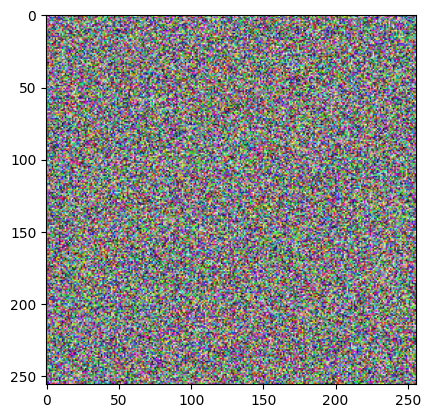

 20%|██        | 101/500 [00:27<01:45,  3.79it/s]

2024-02-23 16:02:32 Epoch 100 | Loss: 73.6219711303711


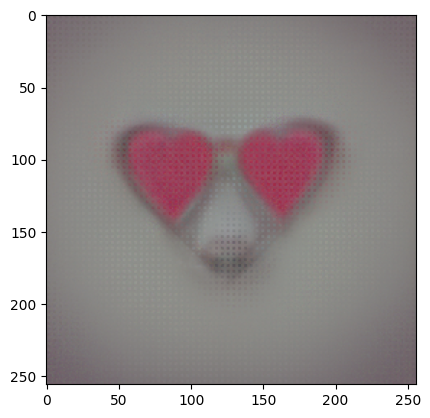

 40%|████      | 201/500 [00:54<01:19,  3.77it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:02:59 Epoch 200 | Loss: 259.92535400390625


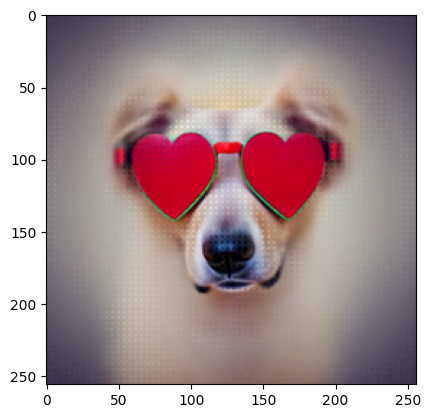

 60%|██████    | 301/500 [01:20<00:52,  3.77it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:03:26 Epoch 300 | Loss: 1469.77783203125


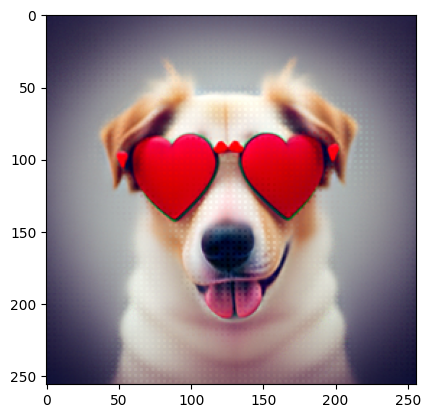

 80%|████████  | 401/500 [01:47<00:26,  3.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:03:52 Epoch 400 | Loss: 1016.751953125


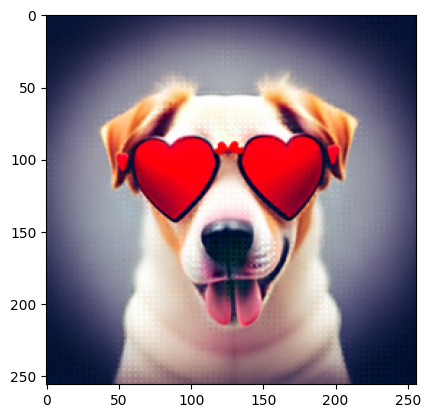

501it [02:14,  3.76it/s]                         Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:04:19 Epoch 500 | Loss: 397.86785888671875


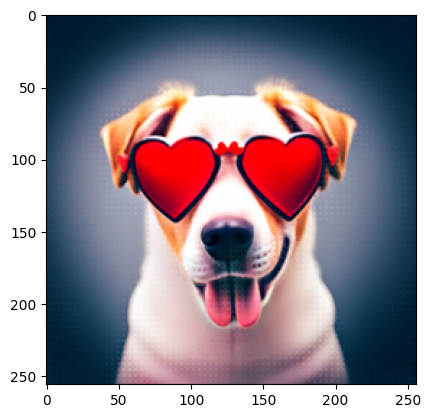

501it [02:14,  3.72it/s]


In [5]:
# Seed everything
seed_everything(1)

# Initialize trainer
cfg = ImageConfig()
trainer = Trainer(cfg)

# Train
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

2024-02-23 16:04:34 Starting edit


  0%|          | 1/500 [00:00<02:22,  3.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:04:34 Epoch 0 | Loss: 71.14203643798828


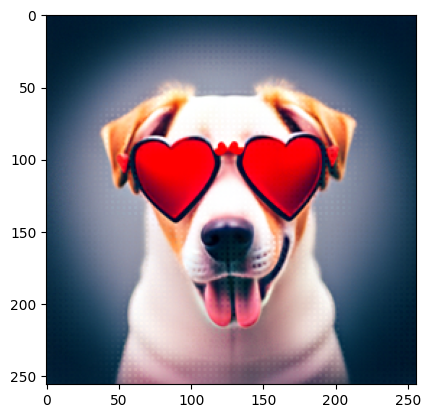

 20%|██        | 101/500 [00:27<01:45,  3.77it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:05:01 Epoch 100 | Loss: 1830.123291015625


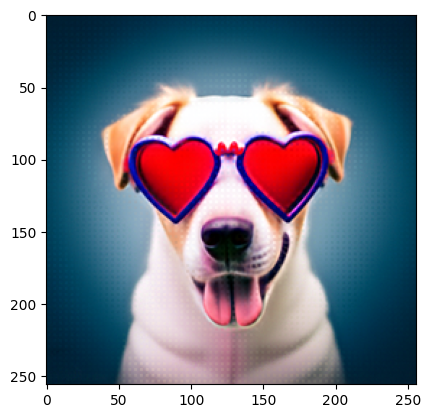

 40%|████      | 201/500 [00:53<01:19,  3.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:05:27 Epoch 200 | Loss: 462.6107177734375


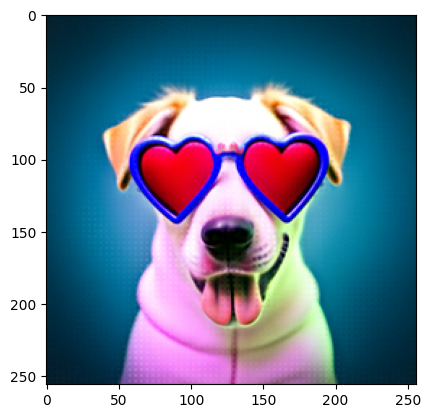

 60%|██████    | 301/500 [01:20<00:52,  3.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:05:54 Epoch 300 | Loss: 131.1263427734375


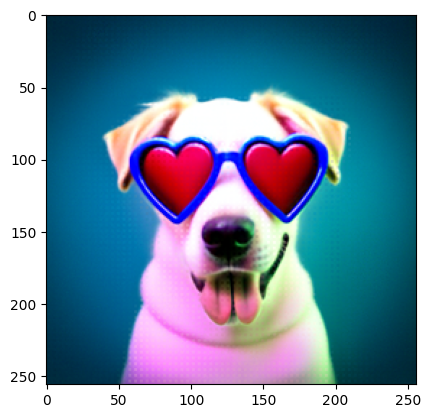

 80%|████████  | 401/500 [01:47<00:26,  3.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:06:21 Epoch 400 | Loss: 661.8673706054688


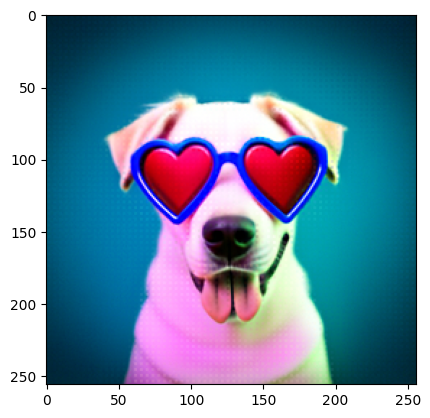

501it [02:14,  3.76it/s]                         Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-23 16:06:48 Epoch 500 | Loss: 227.7235107421875


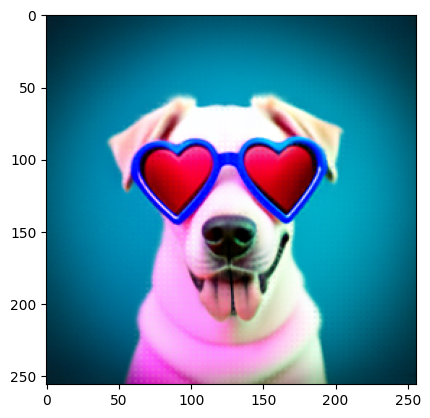

501it [02:14,  3.73it/s]


In [6]:
# Edit
trainer.edit("a dog wearing blue heart-shaped sunglasses")